# <font color='green'>Retooling the bit-flip quantum repetition code to handle phase errors</font>

## <font color='blue'>From bit flips to phase flips</font>

So far, you have learned about the bit-flip quantum repetition code. In complete analogy with the classical setting, the bit-flip quantum repetition code protects information by redundantly encoding a single bit into multiple copies while respecting the no-cloning theorem.

You have also learned how to prepare the logical states $\vert0\rangle_L = \vert000\ldots\rangle$ and $\vert1\rangle_L = \vert111\ldots\rangle$. The logical superposition states are then

$\vert+\rangle_L = \frac{1}{\sqrt{2}}\left(\vert0\rangle_L + \vert1\rangle_L\right) = \frac{1}{\sqrt{2}}\left(\vert000\ldots\rangle + \vert111\ldots\rangle\right)$

and

$\vert+\rangle_L = \frac{1}{\sqrt{2}}\left(\vert0\rangle_L - \vert1\rangle_L\right) = \frac{1}{\sqrt{2}}\left(\vert000\ldots\rangle - \vert111\ldots\rangle\right)$.

The bit-flip repetition code identifies $X$ errors on the logical states $\vert0\rangle_L$ and $\vert1\rangle_L$ by checking the parity of the qubits, two at a time, through measurement of the observables $Z_1Z_2$, $Z_2Z_3$, $Z_3Z_4$ and so on. The effect of an $X$ error on $\vert0\rangle_L$ and $\vert1\rangle_L$ is to simply flip one of the bits, and the pairwise parity checks pick up this error.

Recall that $Z$ errors have no effect on the logical $\vert0\rangle_L$ and $\vert1\rangle_L$ states, since they simply produce an overall phase. These overall phases are not picked up by the parity checks. 

The effect of $Z$ errors on the logical superposition states is different. To see this, recall that $Z_k\vert+\rangle_L = \vert-\rangle_L$ and $Z_k\vert-\rangle_L = \vert+\rangle_L$ for any individual qubit $k$. However, we are unable to detect this _phase-flip_ using our standard $Z_iZ_{i+1}$ parity checks since the bit-wise parities remain unaffected. We will need to modify our syndrome detection procedure in order to protect superposition states against phase flips.

In this chapter, we will make changes to the bit-flip repetition code so that we can protect against phase flips. In the process, we will create the so-called phase-flip repetition code.

## <font color='blue'>Detecting phase flips</font>

Recall that the effect of a phase flip is to transform between $\vert+\rangle$ and $\vert-\rangle$. More explicitly, a phase flip is a $Z$ error such that $Z\vert+\rangle = \vert-\rangle$ and $Z\vert-\rangle = \vert+\rangle$. This phase flip is not detectable through the bit-wise parity checks directly. However, by sandwiching phase-flip errors between Hadamard gates (recall the circuit identity $HZH = X$), we can transform phase flips into bit flips and use our existing toolkit for bit-flip repetition codes. Note that the phase-flip repetition code is therefore measuring $X_iX_{i+1}$ parity checks.

We add a new argument `repcode_type` for this new syndrome measurement for phase-flips.
- For bit-flip repetition codes that use $Z_iZ_{i+1}$ parity checks, `repcode_type = 'Z'`
- For phase-flip repetition codes that use $X_iX_{i+1}$ parity checks, `repcode_type = 'X'`

In [1]:
from math import floor, comb
import numpy as np
import matplotlib.pyplot as plotter
import cirq
from myMWPM import MWPMDecoder1D
import time

In [2]:
def get_syndrome_measurement(qubits, ancilla_qubits, repcode_type = 'Z'):

    syndrome_measurement = []
    for i in range(len(qubits) - 1):
        # Extract the parity of qubits i and i+1 onto ancillary qubit i
        syndrome_measurement.append(cirq.CNOT(qubits[i], ancilla_qubits[i]))
        syndrome_measurement.append(cirq.CNOT(qubits[i+1], ancilla_qubits[i]))
        
    # Measure the ancillary qubits to extract the syndrome
    syndrome_measurement.append(cirq.measure(*ancilla_qubits, key='syndrome'))
    
    return syndrome_measurement

## <font color='blue'>Deciding whether a logical error has occurred</font>

In addition to updating our procedure for detecting phase flips through syndrome measurements, we will also need to update our procedure for deciding whether the information contained in these syndrome measurements constitutes a logical error.

In the bit-flip repetition code scenario, we were protecting the logical states $\vert0\rangle_L$ and $\vert0\rangle_L$. We determined whether a logical error has happened by seeing whether we can use the decoded syndromes to flip the measured data qubits. Importantly, we flipped the **post-measurement** outcomes of the data qubits using the decoded syndromes, and compared it with the initially prepared logical state. If the two matched, then we determined that a logical error didn't happen.

Whenever a logical error _did_ happen, we simply detected that it happened using our syndromes. In principle, we _could have_ **corrected** the error by flipping the relevant data qubits within the circuit, and continued with more operations instead of measuring the data qubits. In fact, our process for measuring the logical error probability (by flipping the **measured** data qubits) assumes that correcting within the circuit **before** the measurements and **after** the measurements produce identical results. However, to correct within the circuit, we would have had to first measure the syndromes, then decode these syndromes to identify error locations, and then apply corrective flips (or keep track of them in software and update future steps). In real quantum systems, the decoder and the associated communication between the decoder and control system around the quantum computer need to operate in concert to avoid a backlog of such syndromes from occurring.

In the phase-flip setting, we can no longer assume that correcting within the circuit **before** the measurements and **after** the measurements produce identical results. This is because we can no longer measure the data qubits (which hold superposition states $\vert+\rangle_L = \frac{1}{\sqrt{2}}\left(\vert000\ldots\rangle + \vert111\ldots\rangle\right)$ and recover the full information about them in one shot. This procedure worked for bit-flip repetition codes, where we were protecting $\vert0\rangle_L = \vert000\ldots\rangle$ or $\vert1\rangle_L=\vert111\ldots\rangle$ from errors, since the data qubits are also measured in the $Z$ basis, which leaves the logical states (flipped or otherwise) unchanged.

Therefore, we will need to update how we determine whether a logical error has occurred. Note that we can no longer simply flip the data qubits using the decoded information and compare the result with the initial state. 

### <font color='red'>Example</font>
Consider the following two scenarios, one in the bit-flip setting, and another in the phase-flip setting, where we know that an error has occurred on qubits 1 and 2.

**Deciding whether a logical error occurred in the _bit-flip_ repetition code**

- Start in logical state $\vert0\rangle_L = \vert000\rangle$
- Bit flips occur on qubits 1 and 2, qubit 0 unaffected. State is now $\vert011\rangle$
- Measured data qubits: [0, 1, 1]
- Syndrome measurements: [1 0]
- Decoded error locations: [0]
- Using the decoded error locations to flip the measured data qubits: [1, 1, 1]
- Compare with known initial state: [1, 1, 1] does not equal [0, 0, 0]
- We decide that <font color='blue'>a logical failure happened.</font>

**Deciding whether a logical error occurred in the _phase-flip_ repetition code**

- Start in logical state $\vert+\rangle_L = \frac{1}{\sqrt{2}}\left(\vert000\ldots\rangle + \vert111\ldots\rangle\right)$
- Phase flips occur on qubits 1 and 2, qubit 0 unaffected. State is now $\frac{1}{\sqrt{2}}\left(\vert011\ldots\rangle + \vert100\ldots\rangle\right)$
- Measured data qubits: [0, 1, 1]
- Syndrome measurements: [1 0]
- Decoded error locations: [0]
- Using the decoded error locations to flip the measured data qubits: [1, 1, 1]
- Compare with known initial state: Initial state could have collapsed to $\vert000\rangle$ or $\vert111\rangle$. Looks like a match to one of these.
- We decide that <font color='red'>a logical failure did not happen!</font>

In both scenarios above, a logical error has indeed happened because 2 qubits (more than half) have flipped in a 3-qubit repetition code. The logical error misleads the decoder toward identifying the wrong qubits as error locations. We decide whether a logical error has occurred by flipping the **post-measurement** information from the data qubits using the misled decoder, and comparing whether this produces the known initial state. In the bit-flip case, we can spot the mismatch and detect the logical error. However, in the phase-flip case, we can be misled into thinking that a logical error did not happen when working with superposition states. This is because we are operating with only partial information about the superposition after measurements of the data qubits.

### <font color='red'>Updating our toolkit</font>

As discussed above, we can no longer assume that correcting within the circuit **before** the measurements and **after** the measurements produce identical results. An error-corrected quantum computer will need to resolve these errors by acting on the syndrome information in real time.

In order to create a plot similar to the one we produced for bit-flip repetition codes comparing the physical and logical error probabilities, we will need to simulate the scenario where the decoder is perfectly keeping up with the information generated by the syndromes, and interpreting the errors correctly when fewer than half the qubits have experienced errors. Then, a logical error occurs when the decoder is unable to interpret the correct error locations because there are too many errors.

Since we cannot infer the correct number of errors that have occurred using the post-measurement information from the data qubits, we will need to find another way to record the ground truth to compare against our decoder. In the code below, we will directly keep track of the errors that have been applied rather than using Cirq's `gate.with_probability()` function. In order to speed up the simulations, we will collect all the circuits and run them in one batch, rather than one by one.

In [3]:
def get_logical_error_probability_for_rep_code(n_qubits, error_probability, 
                                               logical_state = '0', error_gate = cirq.X, 
                                               n_shots = 100, 
                                               simulator = cirq.Simulator(),
                                               repcode_type = 'Z',
                                               ):

    # step 1: build the repetition code circuit without errors
    base_circuit = create_full_repetition_code_circuit(n_qubits, error_probability, logical_state = logical_state, 
                                                       error_gate = error_gate, repcode_type = repcode_type)

    # step 2: generate all errors
    # first, create independent errors in a n_shots x n_qubits matrix
    # then, for each shot, the errors can be taken sliced out of this matrix and applied to the data qubits
    actual_errors_all_shots = []
    error_mask = np.random.random((n_shots, n_qubits)) < error_probability
    for shot in range(n_shots):
        actual_errors_all_shots.append(np.where(error_mask[shot])[0].tolist())

    # step 3: insert all errors into copies of the base_circuit
    circuits = []
    if logical_state == '+':
        insert_index = (1 +                     # initial H gate
                       (n_qubits - 1) +         # CNOT gates to create logical +
                       + 1)                     # H gates to turn phase flips into bit flips
    elif logical_state == '-':
        insert_index = (1 +                     # initial H gate
                        (n_qubits - 1) +        # CNOT gates to create logical +
                        1 +                     # Z gate to turn logical + into logical -
                        1)                      # H gates to turn phase flips into bit flips
    data_qubits = cirq.LineQubit.range(n_qubits)
    for shot_errors in actual_errors_all_shots:
        circuit = base_circuit.copy()
        error_moment = []
        for i in range(n_qubits):
            if i in shot_errors:
                error_moment.append(error_gate(data_qubits[i]))
        if error_moment:
            circuit.insert(insert_index, cirq.Moment(error_moment)) # insert a moment with all errors
        circuits.append(circuit)

    # step 4: run all noise instances (circuits) in one batch
    print(f"Running distance {n_qubits}, {repcode_type}-type rep code, |{logical_state}>_L, error probability {error_probability}")
    t = time.time()
    results = simulator.run_batch(circuits, repetitions=1)
    elapsed = time.time() - t
    print(f"Took {elapsed:.0f} seconds")

    # step 5: decode the syndrome information
    syndromes = [results[i][0].measurements['syndrome'].tolist()[0] for i in range(n_shots)]
    decoder = MWPMDecoder1D(num_qubits=n_qubits)
    decoded_syndromes = [decoder.decode(syndrome) for syndrome in syndromes]

    # step 6: count logical errors
    datas = [results[i][0].measurements['data_qubits'].tolist()[0] for i in range(n_shots)]

    logical_errors = 0
    if repcode_type == 'Z': # bit-flip rep code using ZZ parity checks
        # correct the data qubits using the syndrome measurements and compare with known initial state
        initial_state = [int(logical_state)]*n_qubits
        for data, error_locations in zip(datas, decoded_syndromes):
            final_state = data.copy()
            for error_location in error_locations:
                final_state[error_location] = 1-final_state[error_location] # flip the bit at error_location
            if not np.array_equal(initial_state, final_state):
                logical_errors += 1

    elif repcode_type == 'X': # phase-flip rep code, detecting phase flips by turning them into bit flips
        for actual_error_locations, decoded_error_locations, in zip(actual_errors_all_shots, decoded_syndromes):
            # compare decoder with knowledge of actual error locations
            if not np.array_equal(actual_error_locations, decoded_error_locations):
                logical_errors += 1
            
    return logical_errors * 1. / n_shots

## <font color='blue'>Putting it all together</font>

### <font color='red'>Minor changes in code</font>

In the function `create_full_repetition_code_circuit`, we remove the errors for later insertion by `get_logical_error_probability_for_rep_code` as described above. We also insert the Hadamard gates that convert phase flips into bit flips.

In [4]:
def create_full_repetition_code_circuit(n_qubits, error_probability, error_gate = cirq.X, logical_state = '0', 
                                        repcode_type = 'Z'):

    # Create qubits: data qubits for encoding, ancillary qubits for syndrome measurement
    data_qubits = cirq.LineQubit.range(n_qubits)
    ancilla_qubits = cirq.LineQubit.range(n_qubits, 2*n_qubits - 1)
    
    circuit = cirq.Circuit()

    # Step 0: Decide what quantum state we are protecting. It's either 0 or 1. Then encode it
    encoding_circuit = create_repetition_code_encoder(n_qubits)
    
    # logical state |0>_L = |0000...>
    # do nothing, since all data qubits start reset at |0>.
    if logical_state == '0':
        pass
        
    # logical state |1>_L = |1111...>
    # apply X gate on all data qubits since they all start reset at |0>
    if logical_state == '1':
        circuit.append(
            cirq.Moment(cirq.X(data_qubits[0]))
                       )
        circuit += encoding_circuit
        

    # logical state |+>_L = 1/sqrt(2) * (|0>_L + |1>_L) = 1/sqrt(2) * (|0000...> + |1111...>)
    if logical_state == '+':
        circuit.append(
            cirq.Moment(cirq.H(data_qubits[0]))
                       )
        circuit += encoding_circuit

    # logical state |->_L = 1/sqrt(2) * (|0>_L - |1>_L) = 1/sqrt(2) * (|0000...> - |1111...>)
    if logical_state == '-':
        circuit.append(
            cirq.Moment(cirq.H(data_qubits[0]))
                       )
        circuit += encoding_circuit
        circuit.append(
            cirq.Moment(cirq.Z(data_qubits[0]))
                       )
    
    # Step 1: Hadamard sandwich where phase flips will be inserted
    
    circuit.append(
        cirq.Moment(cirq.H.on_each(*data_qubits))
    )
    
    ## errors go here
    
    circuit.append(
        cirq.Moment(cirq.H.on_each(*data_qubits))
    )
            
    # Step 2: Measure error syndrome
    circuit += get_syndrome_measurement(data_qubits, ancilla_qubits, repcode_type = repcode_type)

    # Step 3: Measure data qubits
    circuit.append(cirq.measure(*data_qubits, key='data_qubits'))
            
    return circuit

In the following functions, we now include the argument `repcode_type` and pass it to the functions that we have modified above. Other than these changes, the functions remain the same as before.

In [5]:
def get_logical_error_probability_simulated(distances, physical_errors, n_shots = 1000000, 
                                            logical_state = '0', error_gate = cirq.X,
                                            simulator = cirq.Simulator(),
                                            repcode_type = 'Z'
                                           ):

    all_logical_errors = []
    for distance in distances:
        print(f"Simulating distance-{distance} repetition code circuits")
        thisdistance_logicalerrors = []
        for physical_error in physical_errors:
            logical_error = get_logical_error_probability_for_rep_code(
                                         n_qubits = distance,
                                         error_probability = physical_error,
                                         logical_state = logical_state,
                                         error_gate = error_gate,
                                         n_shots = n_shots,
                                         repcode_type = repcode_type,
                                         simulator = simulator)
            thisdistance_logicalerrors.append(logical_error)
        all_logical_errors.append(thisdistance_logicalerrors)

    return all_logical_errors

### <font color='red'>No changes in code</font>

The following functions remain exactly the same as before.

In [6]:
def create_repetition_code_encoder(n_qubits):

    qubits = cirq.LineQubit.range(n_qubits)
    circuit = cirq.Circuit()
    
    # The first qubit holds the quantum state
    for i in range(1, n_qubits):
        circuit.append(cirq.CNOT(qubits[0], qubits[i]))

    return circuit

In [7]:
def get_logical_error_probability_analytical(distances, physical_errors):
    
    # method 1: small p approximation
    # all_analytical_errors = []
    # for distance in distances:
    #     t = floor((distance - 1) / 2)
    #     analytical_errors = comb(distance, t+1) * physical_errors**(t+1)
    #     all_analytical_errors.append(analytical_errors)

    # method 2: full expression
    all_analytical_errors = []
    for distance in distances:
        analytical_success = 0
        for i in range(floor(distance/2.)+1):
            analytical_success += comb(distance, i) * physical_errors**i * (1-physical_errors)**(distance-i)
        analytical_errors = 1-analytical_success
        all_analytical_errors.append(analytical_errors)

    return all_analytical_errors

In [8]:
def plot_logical_error_probabilities(distances, physical_errors, all_logical_errors, all_analytical_errors):
    
    plotter.figure(figsize=(10, 8))
    colors = plotter.cm.viridis(np.linspace(0, 0.8, len(distances)))
    
    
    plotter.loglog(physical_errors, physical_errors, label = 'Unprotected qubit',
                      linewidth=2, linestyle = '--', color='gray',
                      )
    for distance, logical_errors, analytical_errors, color in zip(distances, all_logical_errors, all_analytical_errors, colors):
        plotter.loglog(physical_errors, logical_errors, label = f'd = {distance} simulated',
                      marker='o', linewidth=2, markersize=8,
                      color=color,
                      )
        plotter.loglog(physical_errors, analytical_errors, label = f'd = {distance} analytical',
                      linewidth=2, linestyle = '--', color=color,
                      )
    
    plotter.legend()
    plotter.xlim([physical_errors.min(), physical_errors.max()])
    plotter.xlabel('Physical error probability')
    plotter.ylabel('Logical error probability')
    plotter.tight_layout()
    plotter.show()

## <font color='blue'>Running a logical error probability simulation for phase-flip repetition codes</font>

Now, we put the above functions together to run a full simulation of phase-flip repetition codes protecting a logical $\vert+\rangle_L$ state from $Z$ errors.

Simulating distance-3 repetition code circuits
Running distance 3, X-type rep code, |+>_L, error probability 0.001
Took 25 seconds
Running distance 3, X-type rep code, |+>_L, error probability 0.0021544346900318843
Took 26 seconds
Running distance 3, X-type rep code, |+>_L, error probability 0.004641588833612777
Took 26 seconds
Running distance 3, X-type rep code, |+>_L, error probability 0.01
Took 26 seconds
Running distance 3, X-type rep code, |+>_L, error probability 0.021544346900318832
Took 26 seconds
Running distance 3, X-type rep code, |+>_L, error probability 0.046415888336127774
Took 27 seconds
Running distance 3, X-type rep code, |+>_L, error probability 0.1
Took 27 seconds
Running distance 3, X-type rep code, |+>_L, error probability 0.21544346900318823
Took 27 seconds
Running distance 3, X-type rep code, |+>_L, error probability 0.46415888336127775
Took 27 seconds
Running distance 3, X-type rep code, |+>_L, error probability 1.0
Took 28 seconds
Simulating distance-5 repetit

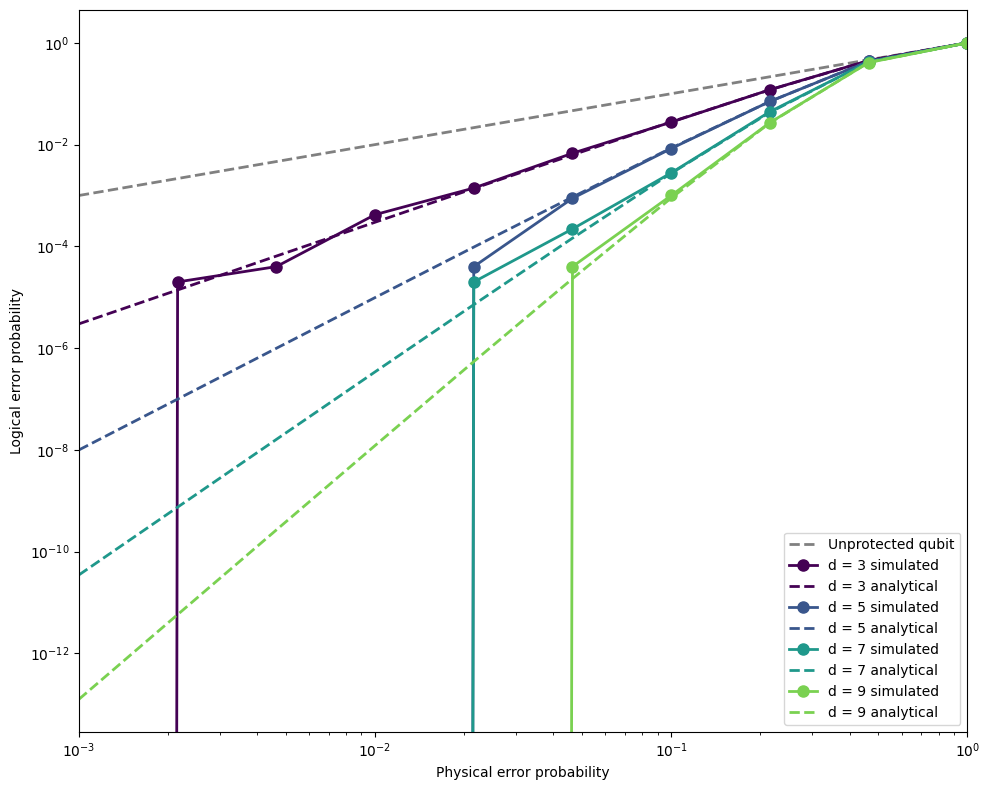

In [9]:
distances = [3, 5, 7, 9]
physical_errors = np.logspace(-3, 0, 10)

all_logical_errors = get_logical_error_probability_simulated(distances, physical_errors, n_shots = 50000, 
                                                             repcode_type = 'X', logical_state = '+', error_gate = cirq.Z, 
                                                             simulator = cirq.CliffordSimulator())
all_analytical_errors = get_logical_error_probability_analytical(distances, physical_errors)
plot_logical_error_probabilities(distances, physical_errors, all_logical_errors, all_analytical_errors)

## <font color='blue'>Summary</font>

In this tutorial, you learned how to construct and test phase-flip repetition codes. While the previously discussed bit-flip repetition codes were completely analogous with the classical setting, phase-flip repetition codes required additional considerations to account for the effect of measurements on superpositions. These two kinds of repetition codes protect from bit-flip or phase-flip errors, but not both at the same time. 

You have also learned that protecting from both kinds of errors will be necessary for general quantum error correction. In the next set of tutorials, you will learn how to implement the surface code -- a 2D extension of the 1D repetition codes that we saw here, which allows for protection from both kinds of errors.